# Waymo: TTC distribution 

- Distribution plot
    - Total
    - Merge
    - Cross 

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot
plt.style.use(['seaborn-v0_8-paper'])
# plt.style.use(['ieee', 'notebook'])

from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
    ))

#Conflicts: 889


/home/gavin/waymo/waymo_devkit/conflict.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  TTCs.append(follower_trajectory_length / (self.follower_beforeConflict_speeds[follower_index]))
/home/gavin/waymo/waymo_devkit/conflict.py:164: RuntimeWarning: divide by zero encountered in double_scalars
  follower_trajectory_length / self.follower_beforeConflict_speeds[follower_index] - \
/home/gavin/waymo/waymo_devkit/conflict.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  leader_trajectory_length / self.leader_beforeConflict_speeds[leader_index]


In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- TTC
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "TTC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for conflict in conflict_list:
    timeToCollision_list = conflict.TTCs
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    PET = conflict.PET
    for TTC in timeToCollision_list:
        conflict_rows_in_df.append([
                conflict_type,
                leader_type+"-"+follower_type,
                PET,
                TTC,
            ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info(), conflict_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50487 entries, 0 to 51298
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  50487 non-null  object 
 1   Vehicle order  50487 non-null  object 
 2   PET            50487 non-null  float64
 3   TTC            50487 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.9+ MB


(None, (50487, 4))

In [4]:
# remove nan value
conflict_df = conflict_df.dropna()
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50487 entries, 0 to 51298
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  50487 non-null  object 
 1   Vehicle order  50487 non-null  object 
 2   PET            50487 non-null  float64
 3   TTC            50487 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.9+ MB


In [5]:
# Post-process: remove TTC greater than 10s
TTC_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["TTC"] <= TTC_THRESHOLD]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23423 entries, 0 to 51265
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  23423 non-null  object 
 1   Vehicle order  23423 non-null  object 
 2   PET            23423 non-null  float64
 3   TTC            23423 non-null  float64
dtypes: float64(2), object(2)
memory usage: 915.0+ KB


In [6]:
conflict_df["Vehicle order"].value_counts()

AV-HV    10179
HV-HV     8869
HV-AV     4375
Name: Vehicle order, dtype: int64

## Distplots

### All

<Figure size 300x300 with 0 Axes>

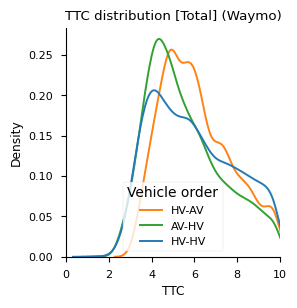

In [7]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="TTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC distribution [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

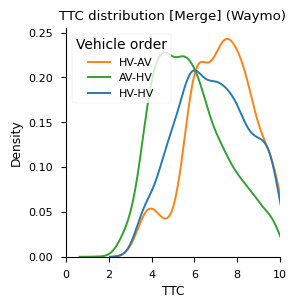

In [8]:
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="TTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

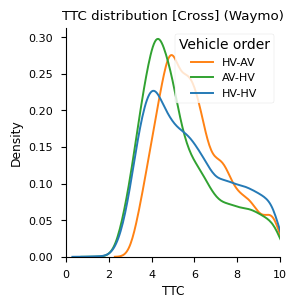

In [9]:
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="TTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()